Author: Lucas Camponogara Viera.

# About TensorFlow

TensorFlow is a library used for tensor (multidimensional array) manipulations and automatic differentiation, i.e., for optimizing parameters through techniques such as gradient descent. Similar to NumPy and CuPy, Tensorflow can be used for linear algebra operations such as inner product (dot product), outer product, matrix-vector, and matrix-matrix multiplications, to name a few.

- Tensorflow (and also NumPy and Pytorch) offers the `tf.einsum` implementation of Einstein summation convention to facilitate linear algebra operations.

- In deep learning, Tensorflow is used for the backend of neural networks that are implemented using Keras (a high-level neural network API).

- When preparing a dataset for deep learning, is a best practice to use TF tensors rather than NumPy arrays for seamless integration.

# Dependencies

In [69]:
import sys
sys.version

'3.12.0 | packaged by conda-forge | (main, Oct  3 2023, 08:43:22) [GCC 12.3.0]'

In [70]:
# Dummy Dataset
import random
import numpy as np

# Tensor Manipulation
import tensorflow as tf

# Neural Network
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, BatchNormalization, Dropout, Activation, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape, Input

# MNIST Dataset
from keras.datasets import mnist

# Preprocessing
from keras.utils import to_categorical

# Optimizer
from keras.optimizers import SGD, RMSprop, Adam 

# Plotting
import matplotlib.pyplot as plt
from keras.utils import plot_model

In [71]:
keras.__version__

'3.10.0'

In [72]:
tf.__version__

'2.19.0'

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# Dummy Dataset

To test the neural network implementation.

In [73]:
# Dummy dataset:
num_classes = 10
num_samples = 100
height = 28
width = height
num_channels = 1 # Grayscale.
train_shape = (num_samples, height, width, num_channels)
label_shape = (num_samples, num_classes)

# Normalizing the dataset:
mean = 0.0 # Mean.
stddev = 1.0 # Standard deviation.

# NumPy:
#dummy_x = np.random.normal(mean, stddev, size=train_shape)
#dummy_y = np.random.normal(mean, stddev, size=label_shape)
#print(dummy_x.mean(), dummy_x.std()) 

# TensorFlow:
dummy_x = tf.random.normal(mean=mean, stddev=stddev, shape=train_shape)
dummy_y = tf.random.normal(mean=mean, stddev=stddev, shape=label_shape) # TensorFlow's categorical_crossentropy loss function expects 
                                                                        # targets (labels) to be one-hot encoded.

dummy_x.shape, dummy_y.shape

(TensorShape([100, 28, 28, 1]), TensorShape([100, 10]))

In [74]:
# Hold-out set:

x_train = dummy_x[:50] # First 50.
y_train = dummy_y[:50]
x_val = dummy_x[50:] # Remaining ones.
y_val = dummy_y[50:]

x_train.shape, y_train.shape, x_val.shape, y_val.shape

(TensorShape([50, 28, 28, 1]),
 TensorShape([50, 10]),
 TensorShape([50, 28, 28, 1]),
 TensorShape([50, 10]))

# Neural Networks

## Sequential API

The Sequential API allows neural network layers to be stacked one after another, sequentially. 

- Recommended for simple, linear models where each layer has exactly one input and one output.
- Not recommended for non-linear models with multiple inputs/outputs, shared layers, or branched architectures (e.g., ResNets, Inception, GANs, Transformer, etc).

In [75]:
'''
Conv2D -> BatchNormalization -> Activation -> MaxPooling2D
Note: It is not recommended to use Dropout and BatchNormalization at the same time.
'''

# Define the model:
model = Sequential()

# Define the input shape:
input_shape, num_classes = (28, 28, 1), 10 # For MNIST dataset.
#input_shape, num_classes = (4,), 3 # For Iris dataset.

# Use Input() as the first layer (best practice):
model.add(Input(shape=input_shape))
    
# Supposing the input is a vector instead of a 3D tensor, one needs to reshape it before using a Conv2D layer:
#model.add(Reshape((2, 2, 1))) # For Conv2D layer.

# Conv Layer:
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same')) 

# Normalization:
model.add(BatchNormalization()) # 128 parameters: 64 trainable (32 gamma + 32 beta) + 64 non-trainable (32 moving mean + 32 moving variance).

# Activation (non-trainable layer):
model.add(Activation('relu')) 

# Pooling Layer to halve the feature map size (non-trainable layer):
model.add(MaxPooling2D((2, 2))) 

# Conv Layer:
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')) 

# Flattening, i.e., converting to a vector (non-trainable layer):
model.add(Flatten()) 

# Dropout (optional - non-trainable layer). 
#model.add(Dropout(0.2)) 

# Dense (fully-connected) Layer:
model.add(Dense(50, activation='relu')) # Out Shape = (batch_size, 50)

# Output Layer uses 10 neurons (10 classes) with softmax activation function for multiclass classification:
model.add(Dense(num_classes, activation='softmax')) # Out Shape = (batch_size, num_classes)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 50)             │       627,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,704 (2.47 MB)

 Trainable params: 646,640 (2.47 MB)

 Non-trainable params: 64 (256.00 B)

In [76]:
sample_input = tf.ones((10, 28, 28, 1)) # Create a sample input with desired shape.
out = model(sample_input) # Pass the input through the model.
out.shape

TensorShape([10, 10])

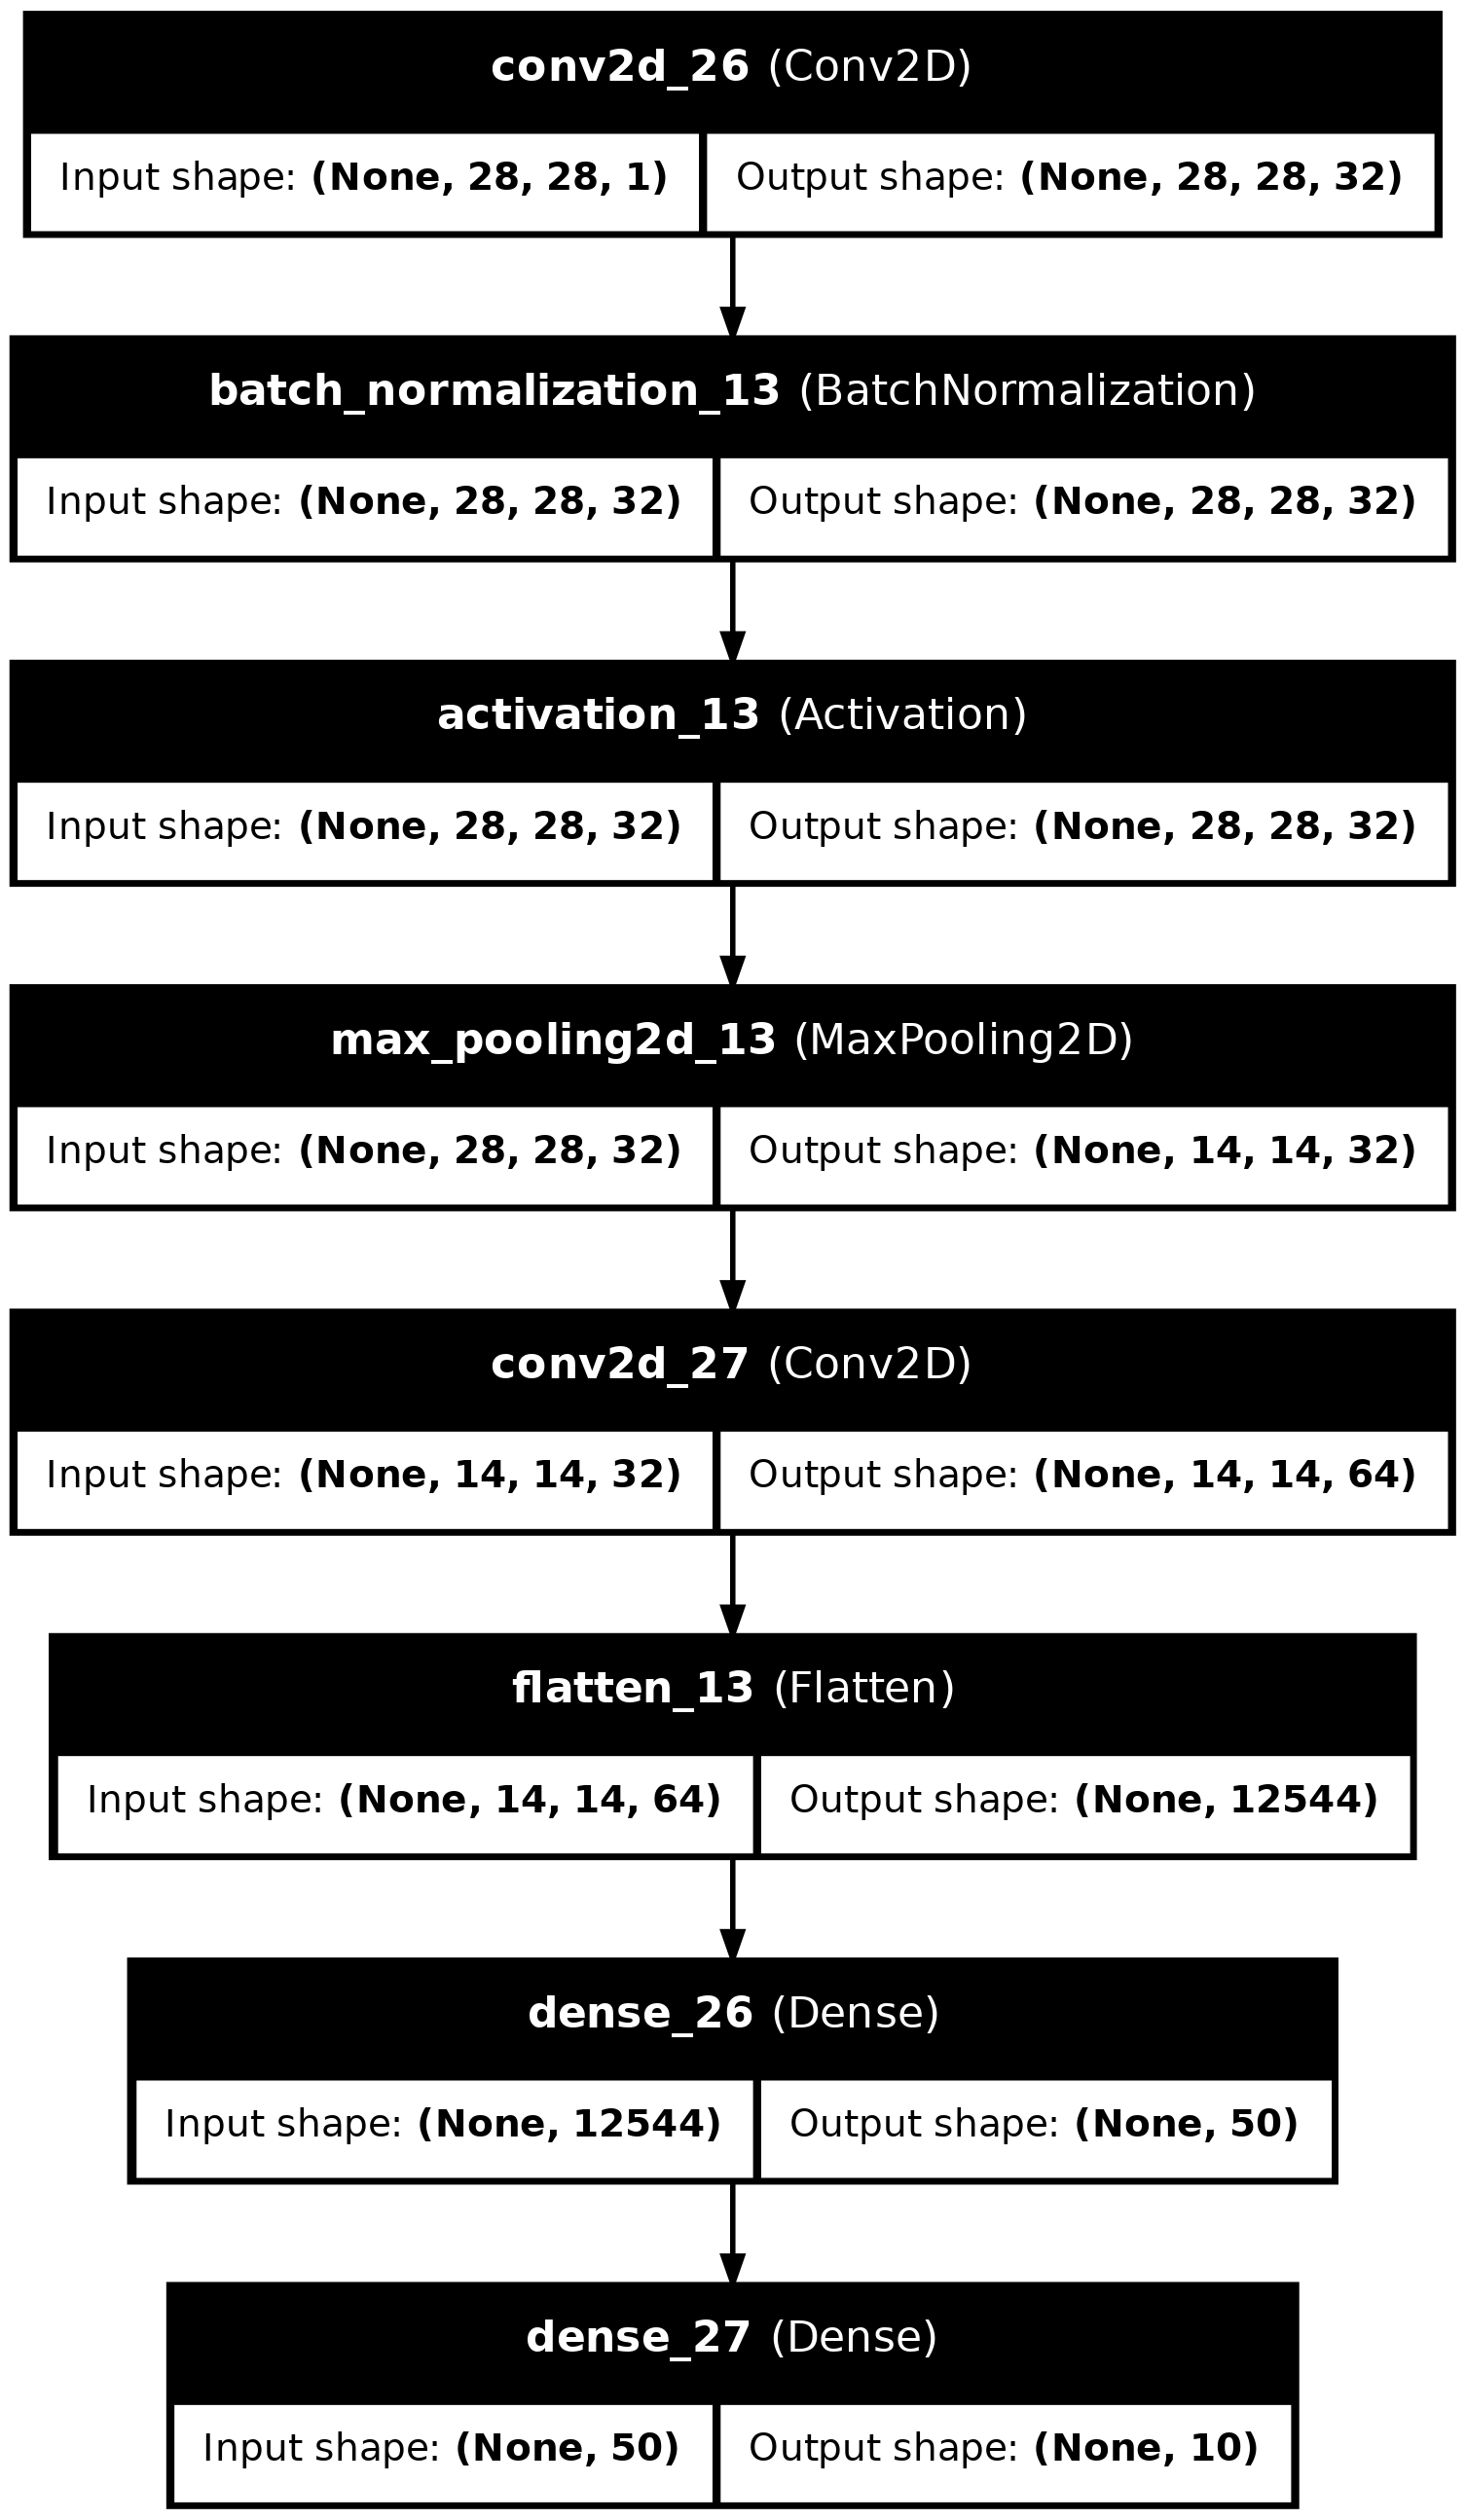

In [77]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Functional API

The Functional API provides a method for building a neural network model as a Directed Acyclic Graph (DAG) of layers. 

- Recommended for non-linear models with multiple inputs/outputs, shared layers, or branched architectures.
    - Example: Implementing a residual block with skip connections. 

In [78]:
'''
Conv2D -> BatchNormalization -> Activation -> MaxPooling2D
Note: It is not recommended to use Dropout and BatchNormalization at the same time.
'''

# Define the input shape:
input_shape, num_classes = (28, 28, 1), 10 # For MNIST dataset.
#input_shape, num_classes = (4,), 3 # For Iris dataset.

# Input Layer:
input_layer = Input(shape=input_shape)

# Reshape input if it is flat (e.g., Iris):
#input_layer = Reshape((2, 2, 1))(input_layer)

# Conv Layer:
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=(1, 1))(input_layer)
assert x.shape == (None, 28, 28, 32), 'Assertion Error, wrong shape!' # MNIST input.
#assert x.shape == (None, 2, 2, 32), 'Assertion Error, wrong shape!' # Iris input.

# Normalization:
x = BatchNormalization()(x)

# Activation (non-trainable):
x = Activation('relu')(x)

# Pooling Layer to halve the feature map size (non-trainable):
x = MaxPooling2D((2, 2))(x)

# Conv Layer:
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(x)

# Flattening, i.e., converting to a vector (non-trainable):
x = Flatten()(x)

# Dropout (non-trainable). 
#x = Dropout(0.2)(x)

# Dense (fully-connected) Layer:
x = Dense(50, activation='relu')(x)
#x = Dense(50)(x)
#x = Activation('relu')(x)

# Output Layer uses 10 neurons (10 classes) with softmax activation function for multiclass classification:
outputs = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_layer, outputs=outputs)

model.summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 50)             │       627,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,704 (2.47 MB)

 Trainable params: 646,640 (2.47 MB)

 Non-trainable params: 64 (256.00 B)

In [79]:
sample_input = tf.ones((10, 28, 28, 1)) # Create a sample input with desired shape.
out = model(sample_input) # Pass the input through the model.
out.shape

TensorShape([10, 10])

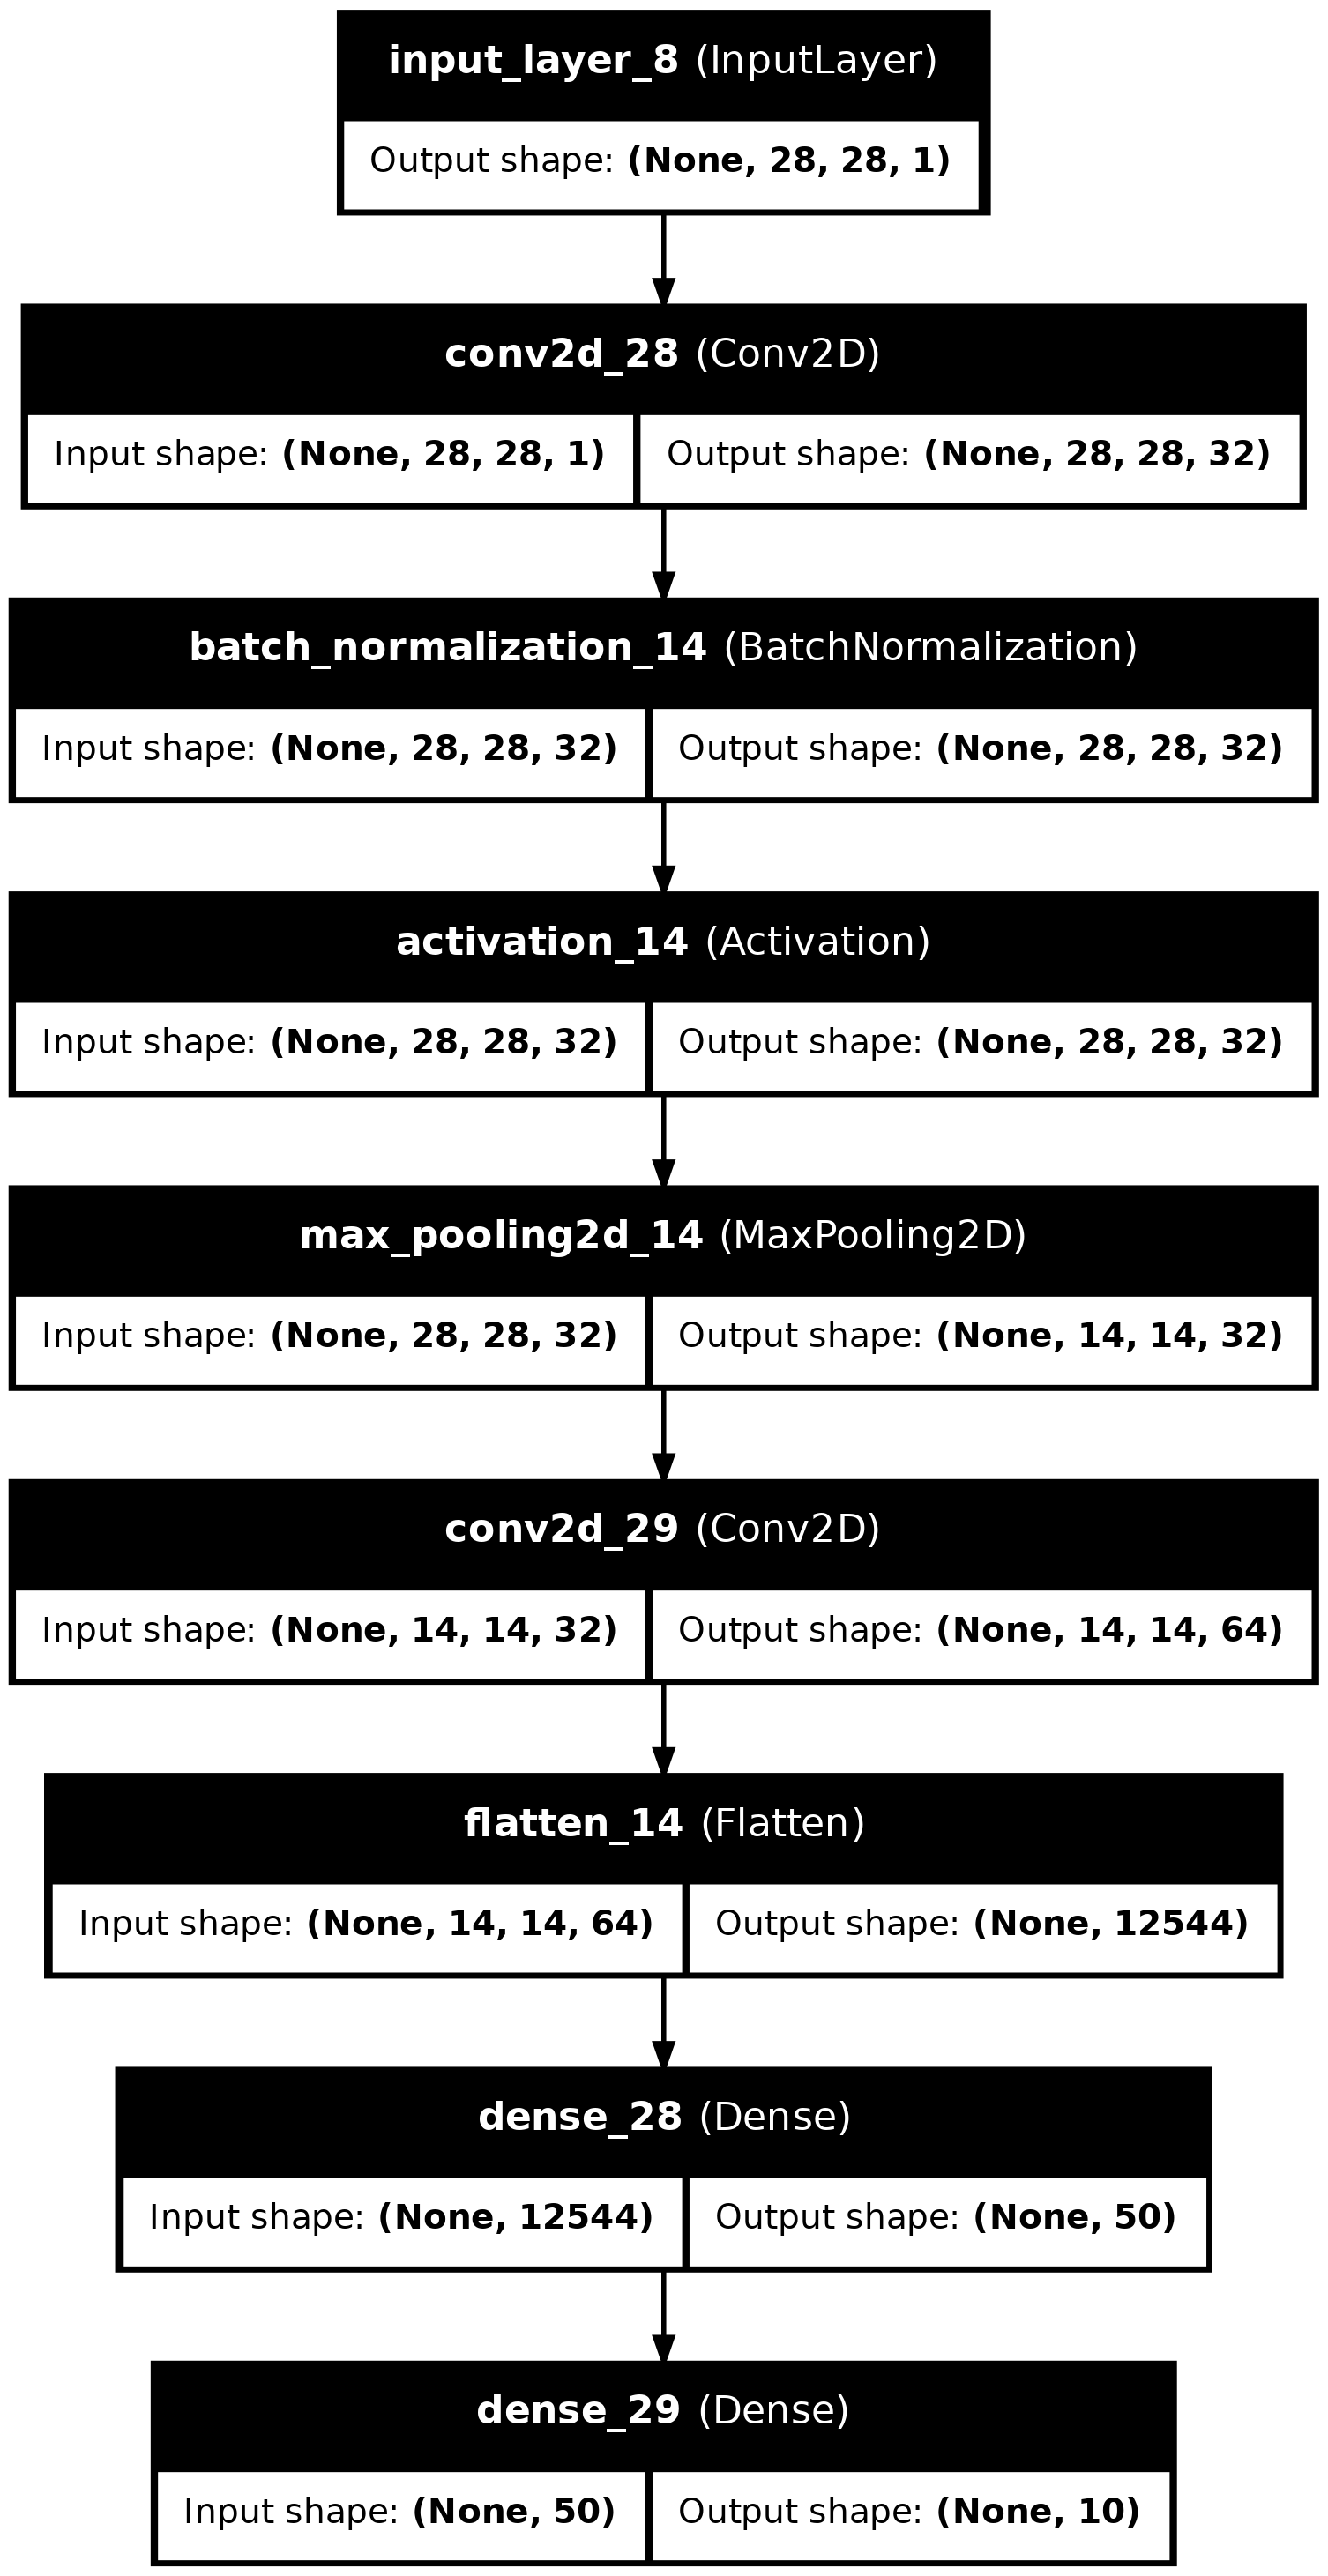

In [80]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Model Subclassing

Model Subclassing involves creating a class that inherits from `tf.keras.Model`. This allows one to define a custom forward pass.

- Recommended for custom forward passes.
    - Examples: A reinforcement learning policy network with multiple heads or a dynamic architecture.

In [81]:
class NeuralNetwork(Model):
    """
    Custom Convolutional Neural Network (CNN) built using the Subclassing API.
    """
    def __init__(self, num_classes):
        """
        Initialize layers for the CNN.

        Args:
            num_classes (int): Number of output classes.
        """
        super().__init__()
        self.conv1 = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', strides=(1, 1))
        self.conv2 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')
        self.batch_norm = BatchNormalization()
        self.activation = Activation('relu')
        self.max_pooling = MaxPooling2D((2, 2))
        self.flatten = Flatten()
        self.dense = Dense(50, activation='relu')
        self.output_layer = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        """
        Forward pass of the network. 
        This method will run automatically when an instance of the class is called.

        Args:
            inputs (tf.Tensor): Input tensor of shape (batch_size, height, width, channels).
            training (bool): Whether the model is in training mode.

        Returns:
            tf.Tensor: Logits after softmax, shape = (batch_size, num_classes).
        """
        x = self.conv1(inputs)
        x = self.batch_norm(x)
        x = self.activation(x)
        x = self.max_pooling(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dense(x)
        return self.output_layer(x)

In [82]:
model = NeuralNetwork(num_classes=10)
sample_input = tf.ones((10, 28, 28, 1)) # Create a sample input with desired shape.
out = model(sample_input) # Pass the input through the model.
model.summary(); out.shape

Model: "neural_network_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (10, 28, 28, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (10, 14, 14, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (10, 28, 28, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (10, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (10, 50)               │       627,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (10, 10)               │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 646,704 (2.47 MB)

 Trainable params: 646,640 (2.47 MB)

 Non-trainable params: 64 (256.00 B)

TensorShape([10, 10])

# Training with MNIST Dataset

## Data Preprocessing

In [83]:
# Loading dataset:
(X, Y), (x_test, y_test) = mnist.load_data()

X.shape, Y.shape, x_test.shape, y_test.shape, type(X)

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,), numpy.ndarray)

In [84]:
# Shuffling indices:

random.seed(1)
size = len(X) # 60k.
indices = random.sample(range(size), size) # A list with 60k random indices from 0 to 59999.

# Splitting the training dataset into training and validation:

x_train = X[indices[:50000]] # First 50k.
y_train = Y[indices[:50000]]
x_val = X[indices[50000:]] # Remaining ones.
y_val = Y[indices[50000:]]

# Scaling features to the range [0, 1]:

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_val = x_val.astype("float32") / 255

x_train.max(), x_val.max(), x_test.max(), type(x_train)

(np.float32(1.0), np.float32(1.0), np.float32(1.0), numpy.ndarray)

In [85]:
for name, arr in zip(['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test'], [x_train, y_train, x_val, y_val, x_test, y_test]):
    print(f"{name} shape: {arr.shape}")

x_train shape: (50000, 28, 28)
y_train shape: (50000,)
x_val shape: (10000, 28, 28)
y_val shape: (10000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [86]:
def one_hot_encode(target: np.ndarray) -> np.ndarray:
    '''
    Convert targets (labels) to one-hot encoding for TensorFlow's categorical_crossentropy loss function.
    
    Args:
      - target (numpy.ndarray): A 1D array of labels. 
    
    Returns:
      - outputs (numpy.ndarray): A 2D array of labels in one-hot encoding format.
    
    Example:
    >>> one_hot_encode(np.array([0,1,3]))
    array([[1., 0., 0., 0.],
           [0., 1., 0., 0.],
           [0., 0., 0., 1.]])
    '''
    no_classes = np.max(target)+1 # Total number of classes.
    new = np.zeros((target.shape[0], no_classes)) # Create a placeholder.
    for i, x in enumerate(target): 
        new[i,x] = 1 
    return new

''' 
# Alternative:

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)
'''

y_train, y_test, y_val = one_hot_encode(y_train), one_hot_encode(y_test), one_hot_encode(y_val)
y_train.shape, y_test.shape, y_val.shape, type(y_train)

((50000, 10), (10000, 10), (10000, 10), numpy.ndarray)

In [87]:
# Converting dataset to TF tensors:

x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
x_val = tf.convert_to_tensor(x_val)
y_val = tf.convert_to_tensor(y_val)
x_test = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test)

# Reshaping tensors to (size, 28, 28, 1):

x_train = tf.reshape(x_train, (x_train.shape[0], 28, 28, 1))
x_val = tf.reshape(x_val, (x_val.shape[0], 28, 28, 1))
x_test = tf.reshape(x_test, (x_test.shape[0], 28, 28, 1))

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

type(x_train), type(y_train), type(x_val), type(y_val), type(x_test), type(y_test)

(50000, 28, 28, 1)
(50000, 10)
(10000, 28, 28, 1)
(10000, 10)
(10000, 28, 28, 1)
(10000, 10)


(tensorflow.python.framework.ops.EagerTensor,
 tensorflow.python.framework.ops.EagerTensor,
 tensorflow.python.framework.ops.EagerTensor,
 tensorflow.python.framework.ops.EagerTensor,
 tensorflow.python.framework.ops.EagerTensor,
 tensorflow.python.framework.ops.EagerTensor)

## Training

In [88]:
# Hyperparameters
learning_rate = 1e-4
momentum = 0.9
epochs = 50
batch_size = 32

# Model
model = NeuralNetwork(num_classes=10)

# Loss
loss = 'categorical_crossentropy'
metrics = 'accuracy'

# Optimizers
optimizer = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True, name='SGD')
#optimizer = RMSprop(learning_rate=learning_rate)
#optimizer = Adam(learning_rate=learning_rate, beta_1 = 0.9, beta_2 = 0.999)

In [23]:
# Compile
model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])

# Train the model
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), batch_size = batch_size, epochs = epochs)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5788 - loss: 1.6388 - val_accuracy: 0.8317 - val_loss: 0.6512
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8694 - loss: 0.4606 - val_accuracy: 0.8927 - val_loss: 0.3655
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8971 - loss: 0.3491 - val_accuracy: 0.9049 - val_loss: 0.3116
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9080 - loss: 0.3114 - val_accuracy: 0.9133 - val_loss: 0.2872
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9162 - loss: 0.2862 - val_accuracy: 0.9193 - val_loss: 0.2660
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9224 - loss: 0.2654 - val_accuracy: 0.9250 - val_loss: 0.2460
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9274 - loss: 0.2472 - val_accuracy: 0.9276 - val_loss: 0.2340
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9322 - loss: 0.2310 - 

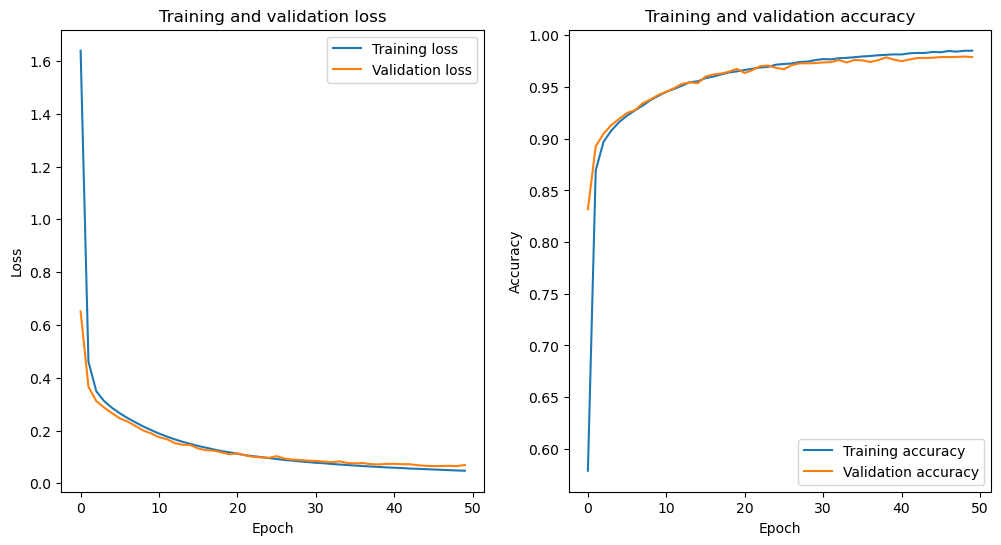

In [24]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the training and validation loss
    ax1.plot(history.history['loss'], label='Training loss')
    ax1.plot(history.history['val_loss'], label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot the training and validation accuracy
    ax2.plot(history.history['accuracy'], label='Training accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation accuracy')
    ax2.set_title('Training and validation accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()
    
plot_history(history)

## Predictions

In [25]:
def get_label(label_array):
    return np.argmax(label_array) # np.argmax returns the position of the highest value.

# Testing
get_label([0,0,1]), get_label(np.random.randint(0, 10, size=10))

(2, 9)

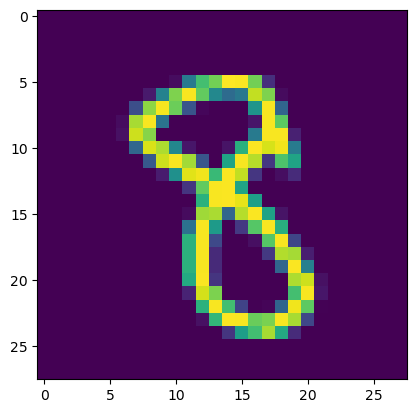

Ground Truth: 8 | Predicted: 8


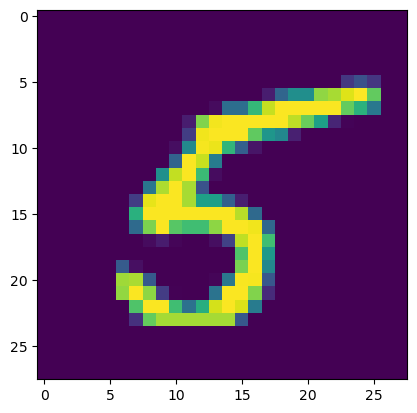

Ground Truth: 5 | Predicted: 5


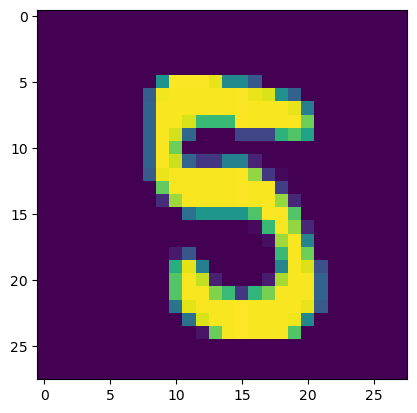

Ground Truth: 5 | Predicted: 5


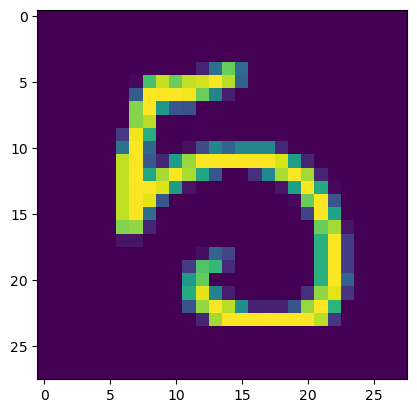

Ground Truth: 5 | Predicted: 5


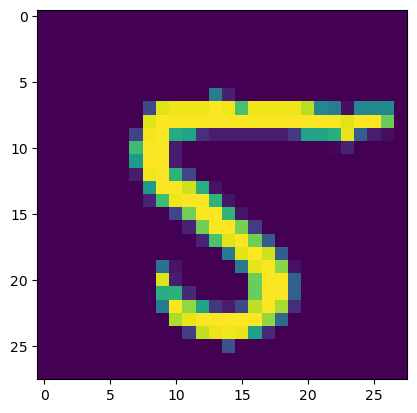

Ground Truth: 5 | Predicted: 5


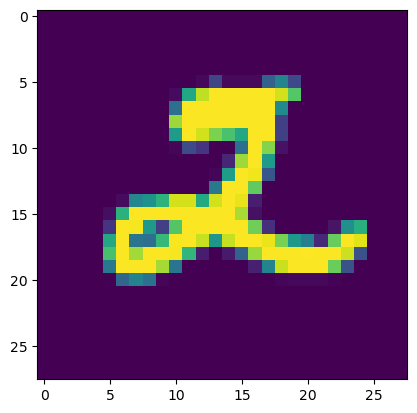

Ground Truth: 2 | Predicted: 2


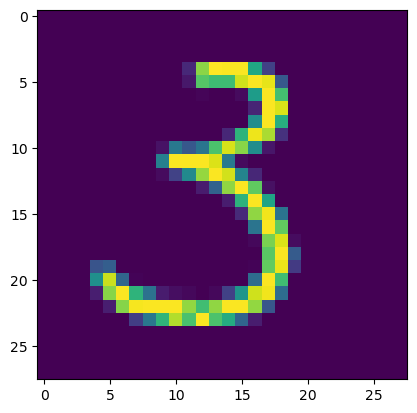

Ground Truth: 3 | Predicted: 3


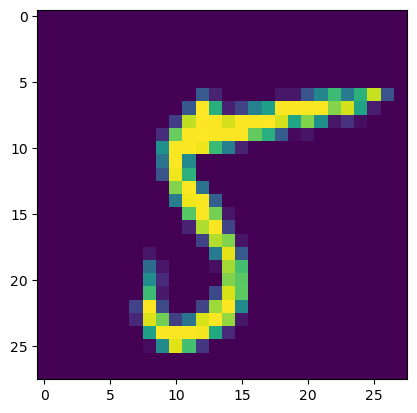

Ground Truth: 5 | Predicted: 5


In [26]:
# Random predictions:

for _ in range(8):
    index = np.random.randint(0, x_test.shape[0])

    sample = x_test[index]                  # (28, 28, 1)
    sample = tf.expand_dims(sample, axis=0) # (1, 28, 28, 1)
    
    ground_truth = get_label(y_test[index])

    predicted = model.predict(sample, verbose=0) # (1, 10)
    predicted = get_label(predicted)             # Label
    
    # Show image
    plt.imshow(tf.reshape(sample, (28, 28)))
    plt.show()
    print(f'Ground Truth: {ground_truth} | Predicted: {predicted}')

In [27]:
# Compute accuracy on validation:

loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.06571284681558609
Test accuracy: 0.9800000190734863
